# FloPy shapefile export demo
The goal of this notebook is to demonstrate ways to export model information to shapefiles.
This example will cover:
* basic exporting of information for a model, individual package, or dataset
* custom exporting of combined data from different packages
* general exporting and importing of geographic data from other sources

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.18.1
matplotlib version: 3.1.2
flopy version: 3.3.4


In [2]:
# set the output directory
outdir = os.path.join('temp', 'shapefile_export')
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# load an existing model
model_ws = "../data/freyberg"
m = flopy.modflow.Modflow.load("freyberg.nam", model_ws=model_ws, verbose=False,
                               check=False, exe_name="mfnwt")

In [3]:
m.get_package_list()

['DIS', 'BAS6', 'LPF', 'WEL', 'RIV', 'RCH', 'OC', 'PCG']

### set the model coordinate information
the coordinate information where the grid is located in a projected coordinate system (e.g. UTM)

In [4]:
grid = m.modelgrid
grid.set_coord_info(xoff=273170, yoff=5088657, epsg=26916)

In [5]:
grid.extent

(273170.0, 278170.0, 5088657.0, 5098657.0)

## Declarative export using attached `.export()` methods
#### Export the whole model to a single shapefile

In [6]:
fname = '{}/model.shp'.format(outdir)
m.export(fname)

c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfdis.py:642: PendingDeprecationWarning: ModflowDis.thickness will be deprecated and removed in version 3.3.5.  Use grid.thick().
  PendingDeprecationWarning,
c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfdis.py:642: PendingDeprecationWarning: ModflowDis.thickness will be deprecated and removed in version 3.3.5.  Use grid.thick().
  PendingDeprecationWarning,
c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfwel.py:281: DeprecationWarning: phiramp_unit will be replaced with iunitramp for consistency
  warnings.warn(err, DeprecationWarning)
c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfwel.py:281: DeprecationWarning: phiramp_unit will be replaced with iunitramp for consistency
  warnings.warn(err, DeprecationWarning)


wrote temp\shapefile_export/model.shp


'temp\\shapefile_export/model.shp'

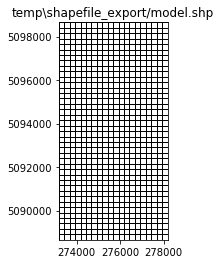

In [7]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = grid.extent
pc = flopy.plot.plot_shapefile(fname, ax=ax, edgecolor='k', facecolor='none')
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(fname);

In [8]:
fname = '{}/wel.shp'.format(outdir)
m.wel.export(fname)

wrote temp\shapefile_export/wel.shp


c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfwel.py:281: DeprecationWarning: phiramp_unit will be replaced with iunitramp for consistency
  warnings.warn(err, DeprecationWarning)
c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfwel.py:281: DeprecationWarning: phiramp_unit will be replaced with iunitramp for consistency
  warnings.warn(err, DeprecationWarning)


### Export a package to a shapefile

### Export a FloPy list or array object

In [9]:
m.lpf.hk

In [10]:
fname = '{}/hk.shp'.format(outdir)
m.lpf.hk.export('{}/hk.shp'.format(outdir))

wrote temp\shapefile_export/hk.shp


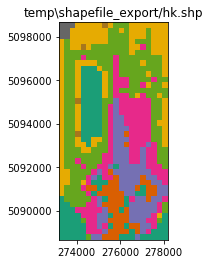

In [11]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = grid.extent
a = m.lpf.hk.array.ravel()
pc = flopy.plot.plot_shapefile(fname, ax=ax, a=a)
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(fname);

In [12]:
m.riv.stress_period_data

In [13]:
m.riv.stress_period_data.export('{}/riv_spd.shp'.format(outdir))

wrote temp\shapefile_export/riv_spd.shp


### MfList.export() exports the whole grid by default, regardless of the locations of the boundary cells
`sparse=True` only exports the boundary cells in the MfList

In [14]:
m.riv.stress_period_data.export('{}/riv_spd.shp'.format(outdir), sparse=True)

wrote temp\shapefile_export/riv_spd.shp


In [15]:
m.wel.stress_period_data.export('{}/wel_spd.shp'.format(outdir), sparse=True)

wrote temp\shapefile_export/wel_spd.shp


## Ad-hoc exporting using `recarray2shp`
* The main idea is to create a recarray with all of the attribute information, and a list of geometry features (one feature per row in the recarray)
* each geometry feature is an instance of the `Point`, `LineString` or `Polygon` classes in `flopy.utils.geometry`. The shapefile format requires all the features to be of the same type.
* We will use pandas dataframes for these examples because they are easy to work with, and then convert them to recarrays prior to exporting.


In [16]:
from flopy.export.shapefile_utils import recarray2shp

### combining data from different packages
write a shapefile of RIV and WEL package cells

In [17]:
wellspd = pd.DataFrame(m.wel.stress_period_data[0])
rivspd = pd.DataFrame(m.riv.stress_period_data[0])
spd = wellspd.append(rivspd)
spd.head()

C:\Users\jlarsen\Documents\anaconda3\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,cond,flux,i,iface,j,k,rbot,stage
0,NaN,-0.00820,8,0.0,15,0,NaN,NaN
1,NaN,-0.00410,10,0.0,12,0,NaN,NaN
2,NaN,-0.00390,19,0.0,13,0,NaN,NaN
3,NaN,-0.00083,25,0.0,9,0,NaN,NaN
4,NaN,-0.00072,28,0.0,5,0,NaN,NaN


##### Create a list of Polygon features from the cell vertices stored in the modelgrid object

In [18]:
from flopy.utils.geometry import Polygon

vertices = []
for row, col in zip(spd.i, spd.j):
    vertices.append(grid.get_cell_vertices(row, col))
polygons = [Polygon(vrt) for vrt in vertices]
polygons

##### write the shapefile

In [19]:
fname = '{}/bcs.shp'.format(outdir)
recarray2shp(spd.to_records(), geoms=polygons,
             shpname=fname,
             epsg=grid.epsg)

wrote temp\shapefile_export/bcs.shp


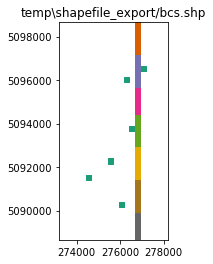

In [20]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = grid.extent
pc = flopy.plot.plot_shapefile(fname, ax=ax)
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(fname);

### exporting other data
Suppose we have some well data with actual locations that we want to export to a shapefile

In [21]:
welldata = pd.DataFrame({'wellID': np.arange(0, 10),
                         'q': np.random.randn(10)*100 - 1000,
                         'x_utm': np.random.rand(10)*5000 + grid.xoffset,
                         'y_utm': grid.yoffset + np.random.rand(10)*10000})
welldata.head()

,wellID,q,x_utm,y_utm
0,0,-1059.646893,277797.678171,5.096207e+06
1,1,-1052.227395,273243.553818,5.094642e+06
2,2,-1051.131124,274226.500471,5.098151e+06
3,3,-1025.060875,277468.863957,5.097615e+06
4,4,-1183.922856,277974.420197,5.092736e+06


##### convert the x, y coorindates to point features and then export

In [22]:
from flopy.utils.geometry import Point
geoms = [Point(x, y) for x, y in zip(welldata.x_utm, welldata.y_utm)]

fname = '{}/wel_data.shp'.format(outdir)
recarray2shp(welldata.to_records(), geoms=geoms,
             shpname=fname,
             epsg=grid.epsg)

wrote temp\shapefile_export/wel_data.shp


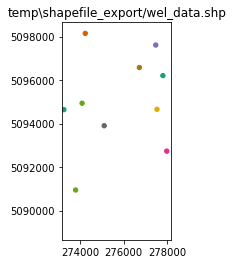

In [23]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = grid.extent
pc = flopy.plot.plot_shapefile(fname, ax=ax, radius=100)
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(fname);

### Adding attribute data to an existing shapefile
Suppose we have a GIS coverage representing the river in the riv package

In [24]:
from flopy.utils.geometry import LineString 

### make up a linestring shapefile of the river reaches
i, j = m.riv.stress_period_data[0].i, m.riv.stress_period_data[0].j
x0 = grid.xyzcellcenters[0][i[0], j[0]]
x1 = grid.xyzcellcenters[0][i[-1], j[-1]]
y0 = grid.xyzcellcenters[1][i[0], j[0]]
y1 = grid.xyzcellcenters[1][i[-1], j[-1]]
x = np.linspace(x0, x1, m.nrow+1)
y = np.linspace(y0, y1, m.nrow+1)
l0 = zip(list(zip(x[:-1], y[:-1])), list(zip(x[1:], y[1:])))
lines = [LineString(l) for l in l0]

rivdata = pd.DataFrame(m.riv.stress_period_data[0])
rivdata['reach'] = np.arange(len(lines))
lines_shapefile = '{}/riv_reaches.shp'.format(outdir)
recarray2shp(rivdata.to_records(index=False), geoms=lines,
             shpname=lines_shapefile,
             epsg=grid.epsg)

wrote temp\shapefile_export/riv_reaches.shp


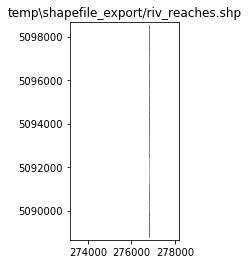

In [25]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = grid.extent
pc = flopy.plot.plot_shapefile(lines_shapefile, ax=ax, radius=25)
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(lines_shapefile);

#### read in the GIS coverage using `shp2recarray`
`shp2recarray` reads a shapefile into a numpy record array, which can easily be converted to a DataFrame

In [26]:
from flopy.export.shapefile_utils import shp2recarray

In [27]:
linesdata = shp2recarray(lines_shapefile)
linesdata = pd.DataFrame(linesdata)
linesdata.head()

,k,i,j,stage,cond,rbot,iface,reach,geometry
0,0,0,14,20.100000,0.05,20.00,0.0,0,<flopy.utils.geometry.LineString object at 0x0...
1,0,1,14,19.870001,0.05,19.75,0.0,1,<flopy.utils.geometry.LineString object at 0x0...
2,0,2,14,19.650000,0.05,19.50,0.0,2,<flopy.utils.geometry.LineString object at 0x0...
3,0,3,14,19.420000,0.05,19.25,0.0,3,<flopy.utils.geometry.LineString object at 0x0...
4,0,4,14,19.190001,0.05,19.00,0.0,4,<flopy.utils.geometry.LineString object at 0x0...


##### Suppose we have some flow information that we read in from the cell budget file

In [28]:
# make up some fluxes between the river and aquifer at each reach
q = np.random.randn(len(linesdata))+1
q

array([ 1.08361669e-01,  1.01206923e+00,  1.26676123e+00,  2.02060968e+00,
        1.50760801e+00,  2.28435472e+00,  1.55579971e+00,  1.89635501e-01,
        5.73534733e-01, -3.03380468e-03,  1.50556671e+00,  2.61773315e-01,
        1.45937402e+00,  1.39104353e+00,  2.03692781e+00,  2.86203668e-01,
        9.92191503e-01,  1.09257580e+00, -1.68260340e-01,  2.22187410e+00,
        2.35274887e+00,  8.66868997e-01,  1.44816429e+00,  7.22702895e-01,
        1.83120987e+00,  8.91021784e-01,  3.05032473e-01,  7.21054281e-01,
        3.37197305e+00,  2.05930693e-01, -9.63242716e-01,  2.00147330e-01,
        1.61131177e+00,  1.23393648e+00, -1.39994364e+00,  9.87599152e-01,
        1.04107216e+00,  1.19459863e+00,  1.86127153e+00,  3.89153486e-01])

##### Add reachs fluxes and cumulative flow to lines DataFrame

In [29]:
linesdata['qreach'] = q
linesdata['qstream'] = np.cumsum(q)

In [30]:
recarray2shp(linesdata.drop('geometry', axis=1).to_records(), 
             geoms=linesdata.geometry.values,
             shpname=lines_shapefile,
             epsg=grid.epsg)

wrote temp\shapefile_export/riv_reaches.shp


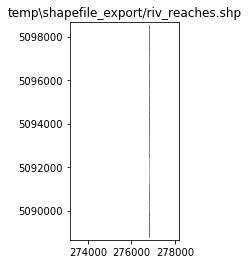

In [31]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = grid.extent
pc = flopy.plot.plot_shapefile(lines_shapefile, ax=ax, radius=25)
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(lines_shapefile);

## Overriding the model's modelgrid with a user supplied modelgrid

In some cases it may be necessary to override the model's modelgrid instance with a seperate modelgrid. An example of this is if the model discretization is in feet and the user would like it projected in meters. Exporting can be accomplished by supplying a modelgrid as a `kwarg` in any of the `export()` methods within flopy. Below is an example:

In [32]:
mg0 = m.modelgrid

# build a new modelgrid instance with discretization in meters
modelgrid = flopy.discretization.StructuredGrid(delc=mg0.delc * 0.3048, delr=mg0.delr * 0.3048,
                                                top= mg0.top, botm=mg0.botm, idomain=mg0.idomain,
                                                xoff=mg0.xoffset * 0.3048, yoff=mg0.yoffset * 0.3048)

# exporting an entire model
m.export('{}/freyberg.shp'.format(outdir), modelgrid=modelgrid)

c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfdis.py:642: PendingDeprecationWarning: ModflowDis.thickness will be deprecated and removed in version 3.3.5.  Use grid.thick().
  PendingDeprecationWarning,
c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfdis.py:642: PendingDeprecationWarning: ModflowDis.thickness will be deprecated and removed in version 3.3.5.  Use grid.thick().
  PendingDeprecationWarning,
c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfwel.py:281: DeprecationWarning: phiramp_unit will be replaced with iunitramp for consistency
  warnings.warn(err, DeprecationWarning)
c:\users\jlarsen\desktop\flopy-dev\flopy\modflow\mfwel.py:281: DeprecationWarning: phiramp_unit will be replaced with iunitramp for consistency
  warnings.warn(err, DeprecationWarning)


wrote temp\shapefile_export/freyberg.shp


'temp\\shapefile_export/freyberg.shp'

And for a specific parameter the method is the same

In [33]:
fname = '{}/hk.shp'.format(outdir)
m.lpf.hk.export(fname, modelgrid=modelgrid)

wrote temp\shapefile_export/hk.shp


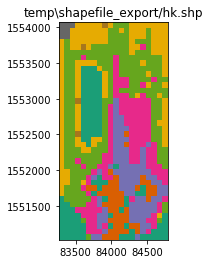

In [34]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = modelgrid.extent
a = m.lpf.hk.array.ravel()
pc = flopy.plot.plot_shapefile(fname, ax=ax, a=a)
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(fname);